<a href="https://colab.research.google.com/github/Arkaprabha1012/pythonopencv/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import tensorflow as tf # for tensorflow based registration
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.util.montage import montage2d
import os
from cv2 import imread, createCLAHE # read and equalize images
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
"""
UNet
The main UNet model implementation
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


# Utility Functions
''' when filter kernel= 3x3, padding=1 makes in&out matrix same size'''
def conv_bn_leru(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
    )

def down_pooling():
    return nn.MaxPool2d(2)

def up_pooling(in_channels, out_channels, kernel_size=2, stride=2):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# UNet class

class UNet(nn.Module):
    def __init__(self, input_channels, nclasses):
        super().__init__()
        # go down
        self.conv1 = conv_bn_leru(input_channels,64)
        self.conv2 = conv_bn_leru(64, 128)
        self.conv3 = conv_bn_leru(128, 256)
        self.conv4 = conv_bn_leru(256, 512)
        self.conv5 = conv_bn_leru(512, 1024)
        self.down_pooling = nn.MaxPool2d(2)

        # go up
        self.up_pool6 = up_pooling(1024, 512)
        self.conv6 = conv_bn_leru(1024, 512)
        self.up_pool7 = up_pooling(512, 256)
        self.conv7 = conv_bn_leru(512, 256)
        self.up_pool8 = up_pooling(256, 128)
        self.conv8 = conv_bn_leru(256, 128)
        self.up_pool9 = up_pooling(128, 64)
        self.conv9 = conv_bn_leru(128, 64)

        self.conv10 = nn.Conv2d(64, nclasses, 1)


        # test weight init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal(m.weight.data, a=0, mode='fan_out')
                if m.bias is not None:
                    m.bias.data.zero_()


    def forward(self, x):
        # go down
        x1 = self.conv1(x)
        p1 = self.down_pooling(x1)
        x2 = self.conv2(p1)
        p2 = self.down_pooling(x2)
        x3 = self.conv3(p2)
        p3 = self.down_pooling(x3)
        x4 = self.conv4(p3)
        p4 = self.down_pooling(x4)
        x5 = self.conv5(p4)

        # go up
        p6 = self.up_pool6(x5)
        x6 = torch.cat([p6, x4], dim=1)
        x6 = self.conv6(x6)

        p7 = self.up_pool7(x6)
        x7 = torch.cat([p7, x3], dim=1)
        x7 = self.conv7(x7)

        p8 = self.up_pool8(x7)
        x8 = torch.cat([p8, x2], dim=1)
        x8 = self.conv8(x8)

        p9 = self.up_pool9(x8)
        x9 = torch.cat([p9, x1], dim=1)
        x9 = self.conv9(x9)


        output = self.conv10(x9)
        output = F.sigmoid(output)

        return output

In [ ]:
import numpy as np
import os
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from data.dataset import get_train_val_loader, inverse_normalize, get_test_loader
from model import UNet
from utils.Config import opt
from utils.vis_tool import Visualizer
from utils.eval_tool import compute_iou, save_pred_result
import utils.array_tool as at

def train(model, train_loader, criterion, epoch, vis):
    model.train()
    batch_loss = 0
    for batch_idx, sample_batched in enumerate(train_loader):
        data = sample_batched['image']
        target = sample_batched['mask']
        data, target = Variable(data.type(opt.dtype)), Variable(target.type(opt.dtype))
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        batch_loss += loss.data[0]
        if (batch_idx+1) % opt.plot_every == 0:
            ori_img_ = inverse_normalize(at.tonumpy(data[0]))
            target_ = at.tonumpy(target[0])
            pred_ = at.tonumpy(output[0])
            vis.img('gt_img', ori_img_)
            vis.img('gt_mask', target_)
            vis.img('pred_mask', (pred_ >= 0.5).astype(np.float32))

    batch_loss /= (batch_idx+1)
    print('epoch: ' + str(epoch) + ', train loss: ' + str(batch_loss))
    with open('logs.txt', 'a') as file:
        file.write('epoch: ' + str(epoch) + ', train loss: ' + str(batch_loss) + '\n')
    vis.plot('train loss', batch_loss)

def val(model, val_loader, criterion, epoch, vis):
    model.eval()
    batch_loss = 0
    avg_iou = 0
    for batch_idx, sample_batched in enumerate(val_loader):
        data = sample_batched['image']
        target = sample_batched['mask']
        data, target = Variable(data.type(opt.dtype), volatile=True), Variable(target.type(opt.dtype), volatile=True)
        output = model.forward(data)
        loss = criterion(output, target)
        batch_loss += loss.data[0]
        avg_iou += compute_iou(pred_masks=at.tonumpy(output >= 0.5).astype(np.float32), gt_masks=target)

    batch_loss /= (batch_idx+1)
    avg_iou /= len(val_loader.dataset)

    print('epoch: ' + str(epoch) + ', validation loss: ' + str(batch_loss), ', avg_iou: ', avg_iou)
    with open('logs.txt', 'a') as file:
        file.write('epoch: ' + str(epoch) + ', validation loss: ' + str(batch_loss) + ', avg_iou: ' + str(avg_iou) + '\n')

    vis.plot('val loss', batch_loss)
    vis.plot('validation average IOU', avg_iou)
    return avg_iou

# train and validation
def run(model, train_loader, val_loader, criterion, vis):
    best_iou = 0
    for epoch in range(1, opt.epochs+1):
        train(model, train_loader, criterion, epoch, vis)
        avg_iou = val(model, val_loader, criterion, epoch, vis)
        if avg_iou > best_iou:
            best_iou = avg_iou
            if opt.save_model:
                save_path = './checkpoints/RSNA_UNet_' + str(round(best_iou, 3)) + '_' + time.strftime('%m%d%H%M')
                torch.save(model.state_dict(), save_path)

    if opt.save_model:
        save_path = './checkpoints/RSNA_UNet_' + str(round(best_iou, 3)) + '_' + time.strftime('%m%d%H%M')
        torch.save(model.state_dict(), save_path)

# make prediction
def run_test(model, test_loader):
    pred_masks = []
    img_ids = []
    images = []
    for batch_idx, sample_batched in tqdm(enumerate(test_loader)):
        data, img_id = sample_batched['image'], sample_batched['img_id']
        data = Variable(data.type(opt.dtype), volatile=True)
        output = model.forward(data)
        # output = (output > 0.5)
        output = at.tonumpy(output)
        for i in range(0, output.shape[0]):
            pred_mask = np.squeeze(output[i])
            id = img_id[i]
            pred_mask = (pred_mask >= 0.5).astype(np.float32)
            pred_masks.append(pred_mask)
            img_ids.append(id)
            ori_img_ = inverse_normalize(at.tonumpy(data[i]))
            images.append(ori_img_)

    return img_ids, images, pred_masks

if __name__ == '__main__':
    """Train Unet model"""
    model = UNet(input_channels=1, nclasses=1)
    if opt.is_train:
        # split all data to train and validation, set split = True
        train_loader, val_loader = get_train_val_loader(opt.root_dir, batch_size=opt.batch_size, val_ratio=0.15,
                                                        shuffle=True, num_workers=4, pin_memory=False)

        optimizer = optim.Adam(model.parameters(), lr=opt.learning_rate, weight_decay=opt.weight_decay)
        criterion = nn.BCELoss()
        vis = Visualizer(env=opt.env)

        if opt.is_cuda:
            model.cuda()
            criterion.cuda()
            if opt.n_gpu > 1:
                model = nn.DataParallel(model)

        run(model, train_loader, val_loader, criterion, vis)
    else:
        if opt.is_cuda:
            model.cuda()
            if opt.n_gpu > 1:
                model = nn.DataParallel(model)
        test_loader = get_test_loader(batch_size=20, shuffle=True,
                                      num_workers=opt.num_workers,
                                      pin_memory=opt.pin_memory)
        # load the model and run test
        model.load_state_dict(torch.load(os.path.join(opt.checkpoint_dir, 'RSNA_UNet_0.895_09210122')))

        img_ids, images, pred_masks = run_test(model, test_loader)

        save_pred_result(img_ids, images, pred_masks)


In [ ]:
!unzip Demo.zip

Archive:  Demo.zip
   creating: Demo/
   creating: Demo/Data/
  inflating: Demo/Data/1-mask.png    
  inflating: Demo/Data/1.jpg         
  inflating: Demo/Data/2-mask.png    
  inflating: Demo/Data/2.jpg         
  inflating: Demo/Data/3-mask.png    
  inflating: Demo/Data/3.jpg         
  inflating: Demo/Data/4-mask.png    
  inflating: Demo/Data/4.jpg         
  inflating: Demo/demo.py            
  inflating: Demo/idx.csv            
  inflating: Demo/results.png        


In [1]:
!wget https://www.dropbox.com/s/9f6e5xjenv10t1g/trained_model.hdf5?dl=0

--2021-03-04 03:28:14--  https://www.dropbox.com/s/9f6e5xjenv10t1g/trained_model.hdf5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/9f6e5xjenv10t1g/trained_model.hdf5 [following]
--2021-03-04 03:28:14--  https://www.dropbox.com/s/raw/9f6e5xjenv10t1g/trained_model.hdf5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd3f0b12b87642f6e69329cea5f.dl.dropboxusercontent.com/cd/0/inline/BKAGnLKk56bzJruAQjSIEnHP4F22mnWvHrn__OEYKbW41zggKZd7YZ0yw0vaQ_C-jQj2UpaxhcnJWR4LftWzgiSL9WxPrvSIRZCEIdumhxCzt0lqPAwLiwQBJtj9oBKGr04/file# [following]
--2021-03-04 03:28:14--  https://ucd3f0b12b87642f6e69329cea5f.dl.dropboxusercontent.com/cd/0/inline/BKAGnLKk56bzJruAQjSIEnHP4F22mnWvHrn__OEYKbW41zggKZd7YZ0yw0vaQ_C-jQj2UpaxhcnJWR4LftWzgiSL

### Dataset loaded
	/content/Demo/Data/
	(4, 256, 256, 1)	(4, 256, 256, 1)
	X:-1.7-1.7	y:0.0-1.0

	X.mean = 8.673617379884035e-17, X.std = 0.9999999999999999
1.jpg 0.9623172576037641 0.9807964033397559
2.jpg 0.954028809363043 0.9764729597419801
3.jpg 0.9567423876268729 0.977892136681762
4.jpg 0.959364238410596 0.9792601806284138
Mean IoU: 0.958113173251069
Mean Dice: 0.9786054200979779


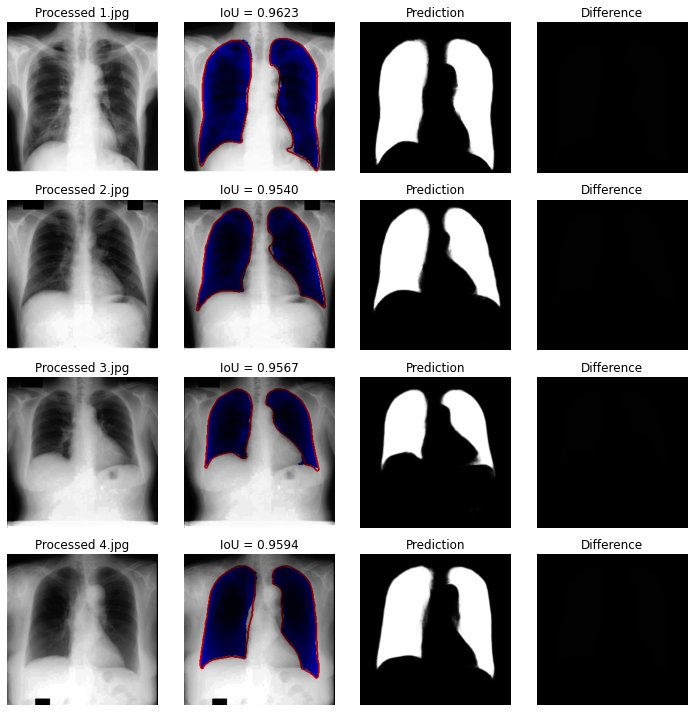

In [ ]:
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from skimage import morphology, io, color, exposure, img_as_float, transform
from matplotlib import pyplot as plt

def loadDataGeneral(df, path, im_shape):
    X, y = [], []
    for i, item in df.iterrows():
        img = img_as_float(io.imread(path + item[0]))
        mask = io.imread(path + item[1])
        img = transform.resize(img, im_shape)
        img = exposure.equalize_hist(img)
        img = np.expand_dims(img, -1)
        mask = transform.resize(mask, im_shape)
        mask = np.expand_dims(mask, -1)
        X.append(img)
        y.append(mask)
    X = np.array(X)
    y = np.array(y)
    X -= X.mean()
    X /= X.std()

    print('### Dataset loaded')
    print('\t{}'.format(path))
    print('\t{}\t{}'.format(X.shape, y.shape))
    print('\tX:{:.1f}-{:.1f}\ty:{:.1f}-{:.1f}\n'.format(X.min(), X.max(), y.min(), y.max()))
    print('\tX.mean = {}, X.std = {}'.format(X.mean(), X.std()))
    return X, y

def IoU(y_true, y_pred):
    """Returns Intersection over Union score for ground truth and predicted masks."""
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    union = np.logical_or(y_true_f, y_pred_f).sum()
    return (intersection + 1) * 1. / (union + 1)

def Dice(y_true, y_pred):
    """Returns Dice Similarity Coefficient for ground truth and predicted masks."""
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    return (2. * intersection + 1.) / (y_true.sum() + y_pred.sum() + 1.)

def masked(img, gt, mask, alpha=1):
    """Returns image with GT lung field outlined with red, predicted lung field
    filled with blue."""
    rows, cols = img.shape
    color_mask = np.zeros((rows, cols, 3))
    boundary = morphology.dilation(gt, morphology.disk(3)) ^ gt
    color_mask[mask == 1] = [0, 0, 1]
    color_mask[boundary == 1] = [1, 0, 0]
    img_color = np.dstack((img, img, img))

    img_hsv = color.rgb2hsv(img_color)
    color_mask_hsv = color.rgb2hsv(color_mask)

    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

    img_masked = color.hsv2rgb(img_hsv)
    return img_masked

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

if __name__ == '__main__':

    # Path to csv-file. File should contain X-ray filenames as first column,
    # mask filenames as second column.
    csv_path = '/content/Demo/idx.csv'
    # Path to the folder with images. Images will be read from path + path_from_csv
    path = '/content/Demo/Data/'

    df = pd.read_csv(csv_path)
    df.head()
    
    # Load test data
    im_shape = (256, 256)
    X, y = loadDataGeneral(df, path, im_shape)

    n_test = X.shape[0]
    inp_shape = X[0].shape

    # Load model
    model_name = 'trained_model.hdf5'
    UNet = load_model(model_name)

    # For inference standard keras ImageGenerator can be used.
    test_gen = ImageDataGenerator(rescale=1.)

    ious = np.zeros(n_test)
    dices = np.zeros(n_test)

    gts, prs = [], []
    i = 0
    plt.figure(figsize=(10, 10))
    for xx, yy in test_gen.flow(X, y, batch_size=1):
        img = exposure.rescale_intensity(np.squeeze(xx), out_range=(0,1))
        pred = UNet.predict(xx)[..., 0].reshape(inp_shape[:2])
        mask = yy[..., 0].reshape(inp_shape[:2])

        gt = mask > 0.5
        pr = pred > 0.5

        pr = remove_small_regions(pr, 0.02 * np.prod(im_shape))

        #io.imsave('{}'.format(df.iloc[i].path), masked(img, gt, pr, 1))

        gts.append(gt)
        prs.append(pr)
        ious[i] = IoU(gt, pr)
        dices[i] = Dice(gt, pr)
        print(df.iloc[i][0], ious[i], dices[i])

        if i < 4:
            plt.subplot(4, 4, 4*i+1)
            plt.title('Processed ' + df.iloc[i][0])
            plt.axis('off')
            plt.imshow(img, cmap='gray')

            plt.subplot(4, 4, 4 * i + 2)
            plt.title('IoU = {:.4f}'.format(ious[i]))
            plt.axis('off')
            plt.imshow(masked(img, gt, pr, 1))

            plt.subplot(4, 4, 4*i+3)
            plt.title('Prediction')
            plt.axis('off')
            plt.imshow(pred,'gray')

            plt.subplot(4, 4, 4*i+4)
            plt.title('Difference')
            plt.axis('off')
            plt.imshow(np.dstack((pr.astype(np.int8), gt.astype(np.int8), pr.astype(np.int8))))

        i += 1
        if i == n_test:
            break

    print('Mean IoU:', ious.mean())
    print('Mean Dice:', dices.mean())
    plt.tight_layout()
    plt.savefig('results1.png')
    plt.show()

### Dataset loaded
	/content/Demo/Data/
	(4, 256, 256, 1)	(4, 256, 256, 1)
	X:-1.7-1.7	y:0.0-1.0

	X.mean = 8.673617379884035e-17, X.std = 0.9999999999999999
1.jpg 0.959364238410596 0.9792601806284138


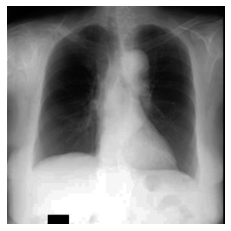

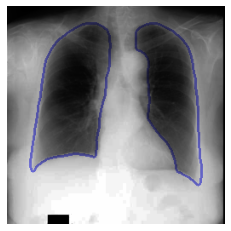

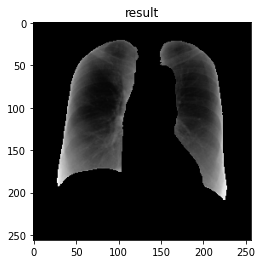

<Figure size 432x288 with 0 Axes>

2.jpg 0.9567423876268729 0.977892136681762


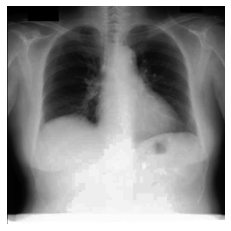

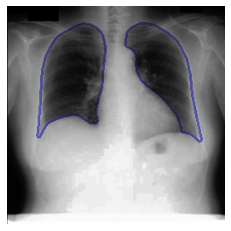

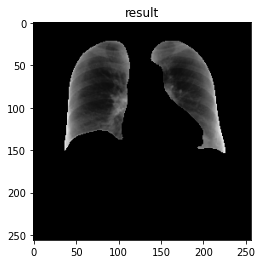

<Figure size 432x288 with 0 Axes>

3.jpg 0.954028809363043 0.9764729597419801


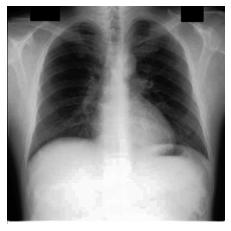

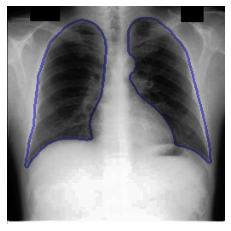

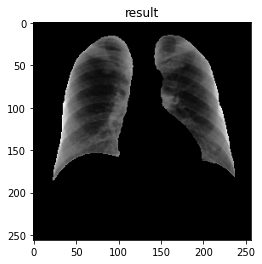

<Figure size 432x288 with 0 Axes>

4.jpg 0.9623172576037641 0.9807964033397559


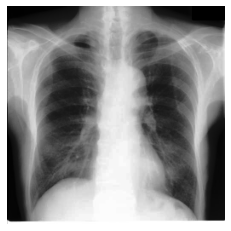

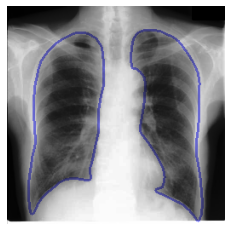

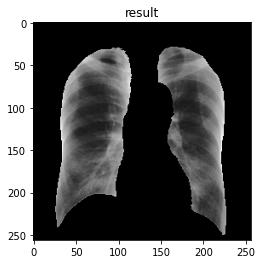

<Figure size 432x288 with 0 Axes>

Mean IoU: 0.958113173251069
Mean Dice: 0.9786054200979779


<Figure size 432x288 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from skimage import morphology, io, color, exposure, img_as_float, transform
from matplotlib import pyplot as plt
import cv2
from keras.preprocessing.image import save_img
import pylab as p
import matplotlib.cm as cm

def loadDataGeneral(df, path, im_shape):
    X, y = [], []
    for i, item in df.iterrows():
        img = img_as_float(io.imread(path + item[0]))
        mask = io.imread(path + item[1])
        img = transform.resize(img, im_shape)
        img = exposure.equalize_hist(img)
        img = np.expand_dims(img, -1)
        mask = transform.resize(mask, im_shape)
        mask = np.expand_dims(mask, -1)
        X.append(img)
        y.append(mask)
    X = np.array(X)
    y = np.array(y)
    X -= X.mean()
    X /= X.std()

    print('### Dataset loaded')
    print('\t{}'.format(path))
    print('\t{}\t{}'.format(X.shape, y.shape))
    print('\tX:{:.1f}-{:.1f}\ty:{:.1f}-{:.1f}\n'.format(X.min(), X.max(), y.min(), y.max()))
    print('\tX.mean = {}, X.std = {}'.format(X.mean(), X.std()))
    return X, y

def IoU(y_true, y_pred):
    """Returns Intersection over Union score for ground truth and predicted masks."""
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    union = np.logical_or(y_true_f, y_pred_f).sum()
    return (intersection + 1) * 1. / (union + 1)

def Dice(y_true, y_pred):
    """Returns Dice Similarity Coefficient for ground truth and predicted masks."""
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    return (2. * intersection + 1.) / (y_true.sum() + y_pred.sum() + 1.)

def masked(img, gt, mask, alpha=127):
    """Returns image with GT lung field outlined with red, predicted lung field
    filled with blue."""
    rows, cols = img.shape
    color_mask = np.zeros((rows, cols, 3))
    boundary = morphology.dilation(gt, morphology.disk(3)) ^ gt
    color_mask[mask == 1] = [0, 0, 0]
    color_mask[boundary == 1] = [1, 1, 2]
    img_color = np.dstack((img, img, img))

    img_hsv = color.rgb2hsv(img_color)
    color_mask_hsv = color.rgb2hsv(color_mask)

    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

    img_masked = color.hsv2rgb(img_hsv)
    return img_masked

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

def interval_mapping(image, from_min, from_max, to_min, to_max):
    # map values from [from_min, from_max] to [to_min, to_max]
    # image: input array
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)

if __name__ == '__main__':

    # Path to csv-file. File should contain X-ray filenames as first column,
    # mask filenames as second column.
    csv_path = '/content/Demo/idx.csv'
    # Path to the folder with images. Images will be read from path + path_from_csv
    path = '/content/Demo/Data/'

    df = pd.read_csv(csv_path)
    df.head()
    
    # Load test data
    im_shape = (256, 256)
    X, y = loadDataGeneral(df, path, im_shape)

    n_test = X.shape[0]
    inp_shape = X[0].shape

    # Load model
    model_name = 'trained_model.hdf5'
    UNet = load_model(model_name)

    # For inference standard keras ImageGenerator can be used.
    test_gen = ImageDataGenerator(rescale=1.)

    ious = np.zeros(n_test)
    dices = np.zeros(n_test)

    gts, prs = [], []
    i = 0
    #plt.figure(figsize=(10, 10))
    for xx, yy in test_gen.flow(X, y, batch_size=1):
        img = exposure.rescale_intensity(np.squeeze(xx), out_range=(0,1))
        pred = UNet.predict(xx)[..., 0].reshape(inp_shape[:2])
        mask = yy[..., 0].reshape(inp_shape[:2])

        gt = mask > 0.5
        pr = pred > 0.5

        pr = remove_small_regions(pr, 0.02 * np.prod(im_shape))

        #io.imsave('{}'.format(df.iloc[i].path), masked(img, gt, pr, 1))

        gts.append(gt)
        prs.append(pr)
        ious[i] = IoU(gt, pr)
        dices[i] = Dice(gt, pr)
        print(df.iloc[i][0], ious[i], dices[i])
        #plt.title('Processed')
        plt.axis('off')
        plt.imshow(img, cmap='gray')
        plt.show()
        #plt.subplot(4, 4, 4 * i + 2)
        #plt.title('IoU = {:.4f}'.format(ious[i]))
        plt.axis('off')
        hey=masked(img, gt, pr, 1)
        plt.imshow(hey)
        plt.show()
        #print("hey")
        #print(hey.shape)
        #save_img("out.jpg",hey)
        #plt.subplot(4, 4, 4*i+3)
        #plt.title('Prediction')
        #plt.axis('off')
        #plt.imshow(pred,'gray')
        #plt.show()
        #print(pred.shape)
        #print(pred)
        #print(img.shape)
        norm_image = cv2.normalize(pred, None, alpha = 0.0, beta = 255.0, norm_type = cv2.NORM_MINMAX)
        pred = norm_image.astype(np.uint8)
        #print(pred.shape)
        #plt.title("PredNormalised")
        #plt.imshow(pred,'gray')
        #plt.show()
        ret,thresh2 = cv2.threshold(pred,127,255,cv2.THRESH_BINARY)
        #pred=cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
        #print(thresh2)
        result2 = (img * thresh2).clip(0, 255).astype(np.uint8)
        plt.title("result")
        plt.imshow(result2,'gray')
        plt.show()
        plt.savefig('grayed.jpg')
        plt.show()
        #plt.subplot(4, 4, 4*i+4)
        hey = cv2.cvtColor(hey, cv2.COLOR_BGR2GRAY)
        #pred=interval_mapping(pred, 0.0, 10.0, 0, 255).astype('uint8')
        #print(pred)
        ret,thresh2 = cv2.threshold(pred,40,255,cv2.THRESH_BINARY)
        #print(thresh2.shape)
        #plt.imshow(thresh2)
        #plt.show()
        #plt.title('Difference')
        #plt.axis('off')
        #plt.imshow(np.dstack((pr.astype(np.int8), gt.astype(np.int8), pr.astype(np.int8))))

        i+=1    
        if i == n_test:
            break

    print('Mean IoU:', ious.mean())
    print('Mean Dice:', dices.mean())
    plt.tight_layout()
    #plt.savefig('results1.png')
    #plt.show()

#Final Lung Segmentation

In [55]:
!unzip Test.zip

Archive:  Test.zip
   creating: Test/
   creating: Test/Data/
  inflating: Test/Data/2cd63b76.jpg  
  inflating: Test/Data/7afaaccc.jpg  
  inflating: Test/Data/80b5f00f.jpg  
  inflating: Test/Data/82a78c13.jpg  
  inflating: Test/Data/441c9cdd.jpg  
  inflating: Test/Data/1052b0fe.jpg  
  inflating: Test/CheckTest.ipynb    
   creating: Test/.ipynb_checkpoints/
  inflating: Test/.ipynb_checkpoints/CheckTest-checkpoint.ipynb  
  inflating: Test/index.csv          
   creating: Test/Preprocessed/


### Dataset loaded
	/content/Test/Data/
	X.mean = 7.93809462606987e-16, X.std = 1.0


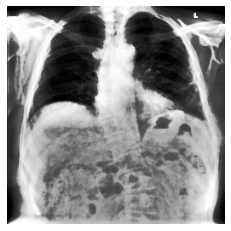

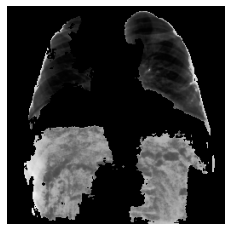

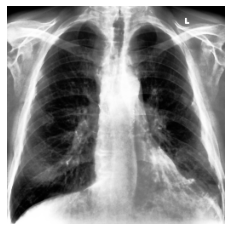

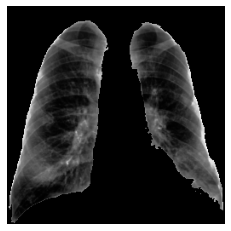

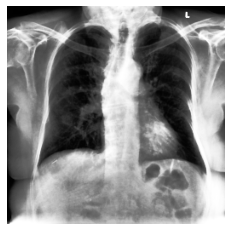

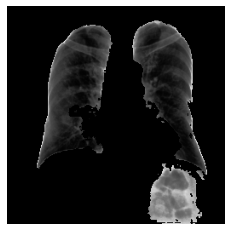

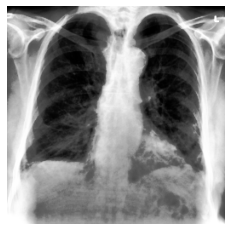

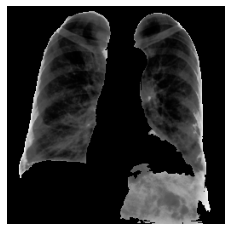

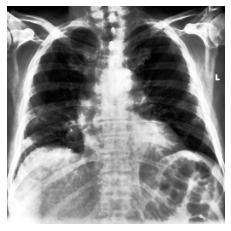

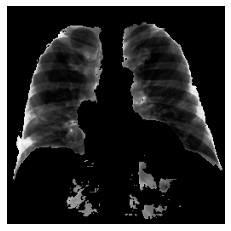

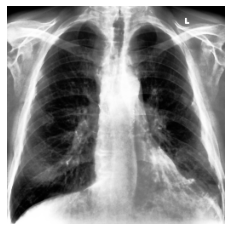

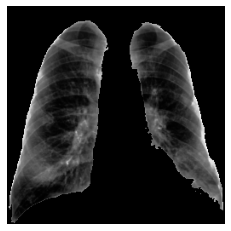

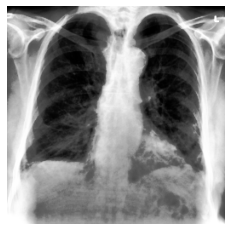

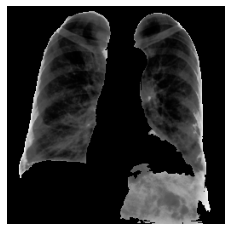

In [58]:
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from skimage import morphology, io, color, exposure, img_as_float, transform
from matplotlib import pyplot as plt
import cv2
from keras.preprocessing.image import save_img
import pylab as p
import matplotlib.cm as cm

def loadDataGeneral(df, path, im_shape):
    X = []
    for i, item in df.iterrows():
        #print(item[0])
        img = img_as_float(io.imread(path + item[0]))
        #print("imgmain1:",img.shape)
        #print("length:",len(img.shape))
        if len(img.shape)==3 and img.shape[2]==3:
          print(img.shape)
          img = np.float32(img)
          img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #mask = io.imread(path + item[1])
        img = transform.resize(img, im_shape)
        #print("imgmain2:",img.shape)
        img = exposure.equalize_hist(img)
        #print("imgmain3:",img.shape)
        img = np.expand_dims(img, -1)
        #print("imgmain4:",img.shape)
        #mask = transform.resize(mask, im_shape)
        #mask = np.expand_dims(mask, -1)
        X.append(img)
        #y.append(mask)
    X = np.array(X)
    #y = np.array(y)
    X -= X.mean()
    X /= X.std()

    print('### Dataset loaded')
    print('\t{}'.format(path))
    #print('\t{}\t{}'.format(X.shape, y.shape))
    #print('\tX:{:.1f}-{:.1f}\ty:{:.1f}-{:.1f}\n'.format(X.min(), X.max(), y.min(), y.max()))
    print('\tX.mean = {}, X.std = {}'.format(X.mean(), X.std()))
    return X

'''def IoU(y_true, y_pred):
    """Returns Intersection over Union score for ground truth and predicted masks."""
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    union = np.logical_or(y_true_f, y_pred_f).sum()
    return (intersection + 1) * 1. / (union + 1)

def Dice(y_true, y_pred):
    """Returns Dice Similarity Coefficient for ground truth and predicted masks."""
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    return (2. * intersection + 1.) / (y_true.sum() + y_pred.sum() + 1.)

def masked(img, gt, mask, alpha=127):
    """Returns image with GT lung field outlined with red, predicted lung field
    filled with blue."""
    rows, cols = img.shape
    color_mask = np.zeros((rows, cols, 3))
    boundary = morphology.dilation(gt, morphology.disk(3)) ^ gt
    color_mask[mask == 1] = [0, 0, 0]
    color_mask[boundary == 1] = [1, 1, 2]
    img_color = np.dstack((img, img, img))

    img_hsv = color.rgb2hsv(img_color)
    color_mask_hsv = color.rgb2hsv(color_mask)

    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

    img_masked = color.hsv2rgb(img_hsv)
    return img_masked

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

def interval_mapping(image, from_min, from_max, to_min, to_max):
    # map values from [from_min, from_max] to [to_min, to_max]
    # image: input array
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)
'''
if __name__ == '__main__':

    # Path to csv-file. File should contain X-ray filenames as first column,
    # mask filenames as second column.
    csv_path ='/content/Test/index.csv'
    # Path to the folder with images. Images will be read from path + path_from_csv
    path ='/content/Test/Data/'

    df = pd.read_csv(csv_path)
    df.head()
    
    # Load test data
    im_shape = (256, 256)
    X = loadDataGeneral(df, path, im_shape)

    n_test = X.shape[0]
    inp_shape = X[0].shape
    # Load model
    model_name = 'trained_model.hdf5'
    UNet = load_model(model_name)

    # For inference standard keras ImageGenerator can be used.
    test_gen = ImageDataGenerator(rescale=1.)

    #ious = np.zeros(n_test)
    #dices = np.zeros(n_test)

    gts, prs = [], []
    i = 0
    #plt.figure(figsize=(10, 10))
    for xx in test_gen.flow(X, batch_size=1):
        img = exposure.rescale_intensity(np.squeeze(xx), out_range=(0,1))
        pred = UNet.predict(xx)[..., 0].reshape(inp_shape[:2])
        #mask = yy[..., 0].reshape(inp_shape[:2])

        #gt = mask > 0.5
        #pr = pred > 0.5

        #pr = remove_small_regions(pr, 0.02 * np.prod(im_shape))

        #io.imsave('{}'.format(df.iloc[i].path), masked(img, gt, pr, 1))

        #gts.append(gt)
        #prs.append(pr)
        #ious[i] = IoU(gt, pr)
        #dices[i] = Dice(gt, pr)
        #print(df.iloc[i][0], ious[i], dices[i])
        #plt.title('Processed')
        plt.axis('off')
        plt.imshow(img,cmap='gray')
        plt.show()
        #plt.subplot(3, 3, 4 * i + 2)
        #plt.title('IoU = {:.4f}'.format(ious[i]))
        plt.axis('off')
        #hey=masked(img, gt, pr, 1)
        #plt.imshow(hey)
        #plt.show()
        #print("hey")
        #print(hey.shape)
        #save_img("out.jpg",hey)
        #plt.subplot(4, 4, 4*i+3)
        #plt.title('Prediction')
        #plt.axis('off')
        #plt.imshow(pred,'gray')
        #plt.show()
        #print(pred.shape)
        #print(pred)
        #print(img.shape)
        norm_image = cv2.normalize(pred, None, alpha = 0.0, beta = 255.0, norm_type = cv2.NORM_MINMAX)
        pred = norm_image.astype(np.uint8)
        #print(pred.shape)
        #plt.title("PredNormalised")
        #plt.imshow(pred,'gray')
        #plt.show()
        ret,thresh2 = cv2.threshold(pred,127,255,cv2.THRESH_BINARY)
        #pred=cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
        #print(thresh2)
        result2 = (img * thresh2)
        plt.imshow(result2,'gray')
        fig=plt.gcf()
        #plt.title("result")
        #plt.imshow(result2,'grey')
        filename='/content/Test/Preprocessed/'+str(i)+"masked.jpg"
        plt.savefig(filename,dpi=100)
        plt.show()
        #plt.subplot(4, 4, 4*i+4)
        #hey = cv2.cvtColor(hey, cv2.COLOR_BGR2GRAY)
        #pred=interval_mapping(pred, 0.0, 10.0, 0, 255).astype('uint8')
        #print(pred)
        #ret,thresh2 = cv2.threshold(pred,40,255,cv2.THRESH_BINARY)
        #print(thresh2.shape)
        #plt.imshow(thresh2)
        #plt.show()
        #plt.title('Difference')
        #plt.axis('off')
        #plt.imshow(np.dstack((pr.astype(np.int8), gt.astype(np.int8), pr.astype(np.int8))))

        i+=1    
        if i == 7:
            break

    #print('Mean IoU:', ious.mean())
    #print('Mean Dice:', dices.mean())
    #plt.tight_layout()
    #plt.savefig('results1.png')
    #plt.show()

In [ ]:
!wget https://www.dropbox.com/s/9f6e5xjenv10t1g/trained_model.hdf5?dl=0

imgmain: (2000, 2000)
imgmain1: (256, 256)
imgmain2: (256, 256)
imgmain3: (256, 256, 1)


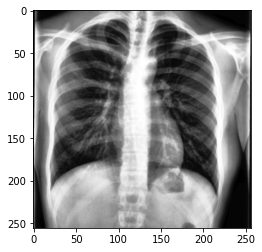

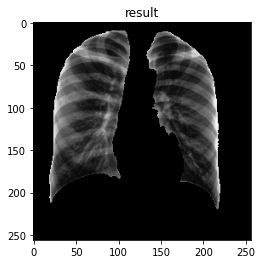

In [5]:
#Packages
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from skimage import morphology, io, color, exposure, img_as_float, transform
from matplotlib import pyplot as plt
import cv2
from keras.preprocessing.image import save_img
import pylab as p
import matplotlib.cm as cm

y=[]
img=img_as_float(io.imread("8.jpg"))
print("imgmain:",img.shape)
if len(img.shape)==3 and img.shape[2]==3:
  img=np.float32(img)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img=transform.resize(img,(256,256))
print("imgmain1:",img.shape)
img=exposure.equalize_hist(img)
print("imgmain2:",img.shape)
img=np.expand_dims(img,-1)
print("imgmain3:",img.shape)
y.append(img)
y=np.array(y)
y -=y.mean()
y /=y.std()
inp_shape=y[0].shape
model_name='trained_model.hdf5'
unet=load_model(model_name)
test_gen=ImageDataGenerator(rescale=1.)
i=0
for xx in test_gen.flow(y,batch_size=1):
    img=exposure.rescale_intensity(np.squeeze(xx),out_range=(0,1))
    pred=unet.predict(xx)[..., 0].reshape(inp_shape[:2])
    plt.imshow(img,cmap='gray')
    plt.show()
    norm_image=cv2.normalize(pred,None,alpha=0.0,beta=255.0,norm_type=cv2.NORM_MINMAX)
    pred=norm_image.astype(np.uint8)
    ret,thresh2=cv2.threshold(pred,127,255,cv2.THRESH_BINARY)
    result=(img*thresh2)
    plt.title('result')
    plt.imshow(result,'gray')
    fig=plt.gcf()
    filename="1masked.jpg"
    plt.savefig(filename,dpi=100)
    plt.show()
    i+=1
    if(i==1):
      break

In [9]:
import pandas as pd 
  
# readinag given csv file 
# and creating dataframe 
dataframe1 = pd.read_csv("/content/Allimages/biggestdata.txt",delimiter = ' ') 
# storing this dataframe in a csv file 
dataframe1.to_csv('alldata.csv',index = None) 

In [6]:
!wget https://www.dropbox.com/s/a0r0mqbt08nfap2/Allimages.zip?dl=0

--2021-03-04 05:56:43--  https://www.dropbox.com/s/a0r0mqbt08nfap2/Allimages.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/a0r0mqbt08nfap2/Allimages.zip [following]
--2021-03-04 05:56:43--  https://www.dropbox.com/s/raw/a0r0mqbt08nfap2/Allimages.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdb54142c8a3d5a2a9bd8a67223.dl.dropboxusercontent.com/cd/0/inline/BKCstY9GwSvLXWPirQYBmY8mgIJXRop_ToxugdS3H2Un_FD5pG3T1MpW54biF34k15UpAXO9Szt7tBJcXkC58eOUun8vws4rq_PUAGIWfSTEq2rWTrCzSiGPhhrj2QKb7LQ/file# [following]
--2021-03-04 05:56:43--  https://ucdb54142c8a3d5a2a9bd8a67223.dl.dropboxusercontent.com/cd/0/inline/BKCstY9GwSvLXWPirQYBmY8mgIJXRop_ToxugdS3H2Un_FD5pG3T1MpW54biF34k15UpAXO9Szt7tBJcXkC58eOUun8vws4rq_PUAGI

In [8]:
!unzip Allimages.zip 

Archive:  Allimages.zip
   creating: Allimages/
  inflating: Allimages/all_images.zip  
  inflating: Allimages/biggestdata.txt  
   creating: Allimages/Segmented/


In [64]:
import pandas as pd
results = pd.read_csv('alldata.csv')
print(len(results))

15475


In [13]:
!unzip '/content/Allimages/all_images.zip'

Streaming output truncated to the last 5000 lines.
  inflating: all_images/831259b0-87f1-41d2-8968-d8a57914eb3b.png  
  inflating: all_images/83bb8d1a-8486-4ee9-885d-17ddffde40fa.png  
  inflating: all_images/83eeeb49-96b9-455a-89ab-425a0e5c471f.png  
  inflating: all_images/83f84af0-3376-4352-8a13-2649e66f35eb.png  
  inflating: all_images/844ac956-e1e2-4f27-b58c-390d6405c3a0.png  
  inflating: all_images/84a5acd8-1e79-4f6b-8cf4-66496fb34314.png  
  inflating: all_images/84c1722d-960c-4191-aee0-54909e2a9814.png  
  inflating: all_images/85345d2f-2530-42cc-8d2a-e660fd8f6236.png  
  inflating: all_images/854290ba-d47b-457b-949e-c86f0e7e5143.png  
  inflating: all_images/85bb48fe-e6d6-47de-bb71-d1636aced7dc.png  
  inflating: all_images/861527f9-8aa7-4c7f-81b7-c8bf6fb68222.png  
  inflating: all_images/86401948-d976-41b5-965a-120a8cc3899a.png  
  inflating: all_images/86b4fe0b-3545-4b94-abcf-7710922257ce.png  
  inflating: all_images/86f92091-0f8b-400e-9a13-f3d61ad724a5.png  
  inflating

In [1]:
!wget https://www.dropbox.com/s/9f6e5xjenv10t1g/trained_model.hdf5?dl=0

--2021-03-04 05:33:11--  https://www.dropbox.com/s/9f6e5xjenv10t1g/trained_model.hdf5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/9f6e5xjenv10t1g/trained_model.hdf5 [following]
--2021-03-04 05:33:11--  https://www.dropbox.com/s/raw/9f6e5xjenv10t1g/trained_model.hdf5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc0e45a936a2e51d9c462fce67c.dl.dropboxusercontent.com/cd/0/inline/BKCPui9x6p2B5t0RxyPMM8RyKRNmMZzvmVeXbyKZsXn1h_ypQi0Cm7qexpfSWi4XCASwiUMC3259G3J7oj59waQMU4QxEPNjG8Xk3Hu3qK0kAGQ-oFZLpTL_ClhV7F88R3E/file# [following]
--2021-03-04 05:33:11--  https://ucc0e45a936a2e51d9c462fce67c.dl.dropboxusercontent.com/cd/0/inline/BKCPui9x6p2B5t0RxyPMM8RyKRNmMZzvmVeXbyKZsXn1h_ypQi0Cm7qexpfSWi4XCASwiUMC3259G3J7oj59waQM

In [11]:
df1=pd.read_csv("alldata.csv")
print(len(df1))

15475


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
done
### Dataset loaded
	/content/all_images/
	X.mean = -8.326672684688674e-17, X.std = 1.0
11
ad7d8292-0c51-49fc-92ba-4d6b8d92df7e.png
ad7d8292-0c51-49fc-92ba-4d6b8d92df7e.png


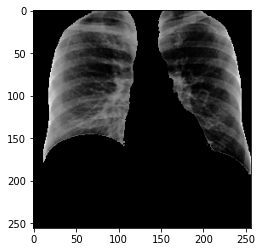

In [25]:
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from skimage import morphology, io, color, exposure, img_as_float, transform
from matplotlib import pyplot as plt
import cv2
from keras.preprocessing.image import save_img
import pylab as p
import matplotlib.cm as cm

def loadDataGeneral(df, path, im_shape):
    X = []
    filen=[]
    for i, item in df.iterrows():
        img = img_as_float(io.imread(path + item[1]))
        filen.append(item[1])
        print(item[1]," Loaded ")
        if len(img.shape)==3 and img.shape[2]==3:
          print(img.shape)
          img = np.float32(img)
          img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = transform.resize(img, im_shape)
        img = exposure.equalize_hist(img)
        img = np.expand_dims(img, -1)
        X.append(img)
        if i==15474:
          break
    print("done")    
    X = np.array(X)
    X -= X.mean()
    X /= X.std()

    print('### Dataset loaded')
    print('\t{}'.format(path))
    print('\tX.mean = {}, X.std = {}'.format(X.mean(), X.std()))
    print(len(filen))
    print(filen[0])
    return X,filen
if __name__ == '__main__':

    # Path to csv-file. File should contain X-ray filenames as first column,
    # mask filenames as second column.
    csv_path ='alldata.csv'
    # Path to the folder with images. Images will be read from path + path_from_csv
    path ='/content/all_images/'

    df = pd.read_csv(csv_path)
    df.head()
    
    # Load test data
    im_shape = (256, 256)
    X,filen1 = loadDataGeneral(df, path, im_shape)
    print(filen1[0])
    #n_test = X.shape[0]
    inp_shape = X[0].shape
    # Load model
    model_name = 'trained_model.hdf5'
    UNet = load_model(model_name)

    # For inference standard keras ImageGenerator can be used.
    test_gen = ImageDataGenerator(rescale=1.)
    i = 0
    #plt.figure(figsize=(10, 10))
    for xx,filen in test_gen.flow(X,filen1, batch_size=1):
        img = exposure.rescale_intensity(np.squeeze(xx), out_range=(0,1))
        pred = UNet.predict(xx)[..., 0].reshape(inp_shape[:2])
        norm_image = cv2.normalize(pred, None, alpha = 0.0, beta = 255.0, norm_type = cv2.NORM_MINMAX)
        pred = norm_image.astype(np.uint8)
        ret,thresh2 = cv2.threshold(pred,127,255,cv2.THRESH_BINARY)
        result2 = (img * thresh2)
        plt.imshow(result2,cmap="gray")
        fig=plt.gcf()
        i+=1
        filename='/content/Allimages/Segmented/'+filen1[i]
        plt.savefig(filename,dpi=100)
        print(filen1[i]," Segmentation Done.")
        if i == 15474:
            break